# Учебный Проект → «быстро узнать рыночную стоимость» 🚗

## Цель проекта

> Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

## Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения;

Импортируем библиотеки 🎒

In [ ]:
import re
import lightgbm
import big_o
import requests
import json

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from numpy.random import RandomState
from numpy.random import rand
from numpy.random import choice

from matplotlib import rcParams

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline

from catboost import CatBoostRegressor

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
            }

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [ ]:
RANDOM_SEED = 108108108
RANDOM_NP = RandomState(128)
API_KEY = 'e41900fa9140614e6248ae4bd1a09194'
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [6]:
def columns_w_na(data_df):
    col_nan = data_df.columns[
            data_df.isna().any()
        ].tolist()
    df_length = len(data_df.index)
    print('Колонки с NaN:')
    
    for col in col_nan:
        count_na = len(
                data_df.loc[data_df[col].isna()].index
            )
        
        print(
            '{: .2%}'.format(count_na/df_length),
            end='\t→ '
        )
        print(col, end=' → ')
        print(count_na)

In [7]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    columns_w_na(data_df)
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
    )

In [8]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [9]:
def plot_hist(data, title='Histogram', custom_params=custom_params):
    
    num_col = 2
    num_row = int(
            len(data.columns) / num_col
        ) + (len(data.columns) % num_col)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=num_row,
            ncols=num_col,
            figsize=(
                to_px(960), to_px(960)),
            tight_layout=True
        )
        
        for n, col_name in enumerate(data.columns):
            ax_row = int(n/2)
            ax_col = n%2
            n_bins = len(data[col_name].unique())
                
            axs[ax_row, ax_col].hist(
                data[col_name],
                bins=n_bins,
                color='forestgreen'
            )
            axs[ax_row, ax_col].set_title(col_name)
        
        fig.suptitle(title, fontsize=16)
        
        if len(data.columns) % num_col:
            fig.delaxes(axs[-1, -1])

        plt.show()

<hr>

## Загрузка данных

### 1.1. Загрузим файл

In [10]:
try:
    autos_df = pd.read_csv(
        './datasets/autos.csv',
    )
    
except FileNotFoundError:
    autos_df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/autos.csv',
    )
    print('FYI datasets loaded via url')

Сделаем названия столбцов по+красоте → `snake_case`

In [11]:
autos_df.columns  = pd.Series(autos_df.columns).apply(
    lambda c: re.sub(r'(?<!^)(?=[A-Z])', '_',  c ).lower()
)

### 1.2. Изучим данные

In [12]:
baisic_df_info(autos_df)

Basic Info

Дубликатов: 4

Колонки с NaN:
 10.58%	→ vehicle_type → 37490
 5.60%	→ gearbox → 19833
 5.56%	→ model → 19705
 9.28%	→ fuel_type → 32895
 20.08%	→ repaired → 71154
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354

None

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
348922,2016-03-09 13:53:08,600,sedan,1997,manual,0,a3,150000,3,NaN,audi,no,2016-03-09 00:00:00,0,73037,2016-03-15 14:46:56
36313,2016-03-28 00:39:54,3999,small,2008,manual,60,fabia,100000,11,petrol,skoda,no,2016-03-27 00:00:00,0,41372,2016-04-04 01:47:05
225100,2016-03-19 18:52:30,60,NaN,2000,NaN,0,kadett,5000,0,NaN,opel,NaN,2016-03-19 00:00:00,0,18337,2016-03-24 14:45:35
88326,2016-03-09 12:53:53,3800,NaN,2016,manual,180,tt,150000,0,petrol,audi,NaN,2016-03-09 00:00:00,0,53125,2016-03-09 12:53:53
344484,2016-03-24 18:31:07,8750,wagon,2008,manual,102,golf,70000,6,petrol,volkswagen,no,2016-03-24 00:00:00,0,65779,2016-04-06 04:45:15


,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [13]:
start_df_length = len(autos_df.index)
print(
    'Колличество строк в наборе данных до обработки',
    start_df_length
)

Колличество строк в наборе данных до обработки 354369


### Признаки

- `date_crawled` — дата скачивания анкеты из базы
- `vehicle_type` — тип автомобильного кузова
- `registration_year` — год регистрации автомобиля
- `gearbox` — тип коробки передач
- `power` — мощность (л. с.)
- `model` — модель автомобиля
- `kilometer` — пробег (км)
- `registration_month` — месяц регистрации автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `repaired` — была машина в ремонте или нет
- `date_created` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля
- `postal_code` — почтовый индекс владельца анкеты (пользователя)
- `last_seen` — дата последней активности пользователя

### Целевой признак
- `price` — цена (евро)

Все значения в `number_of_pictures` равны нуль, проверим ещё раз и удалим колонку.

In [14]:
display(
    list(
        autos_df['number_of_pictures'].unique()
    )
)

[0]

In [15]:
autos_df.drop(
    columns='number_of_pictures',
    inplace=True,
)

Очень маловероятно, что параметр `last_seen` влияет на стоимость автомобиля.  
Хотя, можно было бы проверить гипотезу:  
Если давно не заходил в аккаунт, значит цена завышена.  

In [16]:
autos_df.drop(
    columns='last_seen',
    inplace=True,
)

In [17]:
zero_price_idx = autos_df.loc[autos_df['price'] == 0].index
display(
    len(
        zero_price_idx
    )
)

10772

Такой `нулевой` целевой признак `price` не нужен)  
Удалим строки с нулевой ценой.  

Среднюю цену и `DummyRegression` может спрогназировать, нам важна точность 🤌

In [18]:
autos_df.drop(
    index=zero_price_idx,
    inplace=True,
)

In [19]:
print('Строк с price == 0 →', len(zero_price_idx))
print('Всего {:.2%}'.format(len(zero_price_idx) / start_df_length))

Строк с price == 0 → 10772
Всего 3.04%


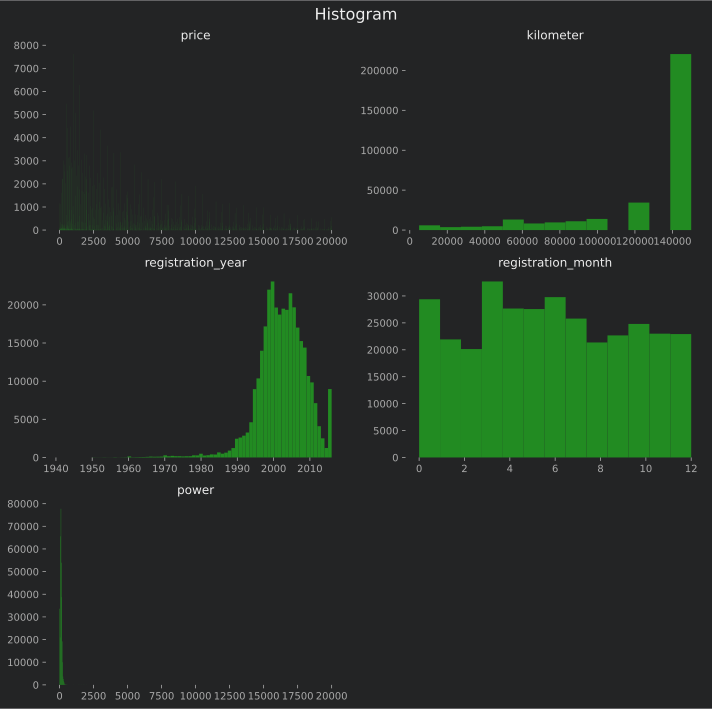

In [20]:
plot_hist(data=autos_df.loc[
    (autos_df['registration_year'] < 2017)
    & (autos_df['registration_year'] > 1940),
        [
            'price',
            'kilometer',
            'registration_year',
            'registration_month',
             'power',
        ]
   ]
)

<hr>

## 2. Подготовим данные

### 2.1. Заполним пропущенные значения и обработаем аномалии в данных

> Заполните пропущенные значения и обработайте аномалии в столбцах.

In [22]:
categorical_col = {
    'vehicle_type': 'category',
    'gearbox': 'category',
    'model': 'category',
    'fuel_type': 'category',
    'brand': 'category',
    'repaired': 'category',
    'postal_code': 'category',
}

numeric_col = [
    'price',
    'power',
    'kilometer',
    'registration_year',
]

date_col = [
    'date_crawled',
    'registration_year',
    'registration_month',
    'date_created',
]
col_types = {
        'price': 'uint32',
        'power': 'uint16',
        'kilometer': 'uint32',
        'registration_year': 'uint16',
        'registration_month': 'uint8',
}

In [23]:
def descr_intervals(data_df, title='99% и 95% интервалы', perc=[.005, .025,  .5, .975, .995]):
    print(title)

    display(
        pd.DataFrame(
            data=data_df.describe(percentiles=perc).values,
            index=data_df.describe(percentiles=perc).index,
            columns=data_df.columns
        )
    )

In [24]:
def idx_by_quantiles (data_df, col_list, start_quant=.005, end_quant=.995, intrpltn='nearest'):
    """idx_by_quantiles returns combined inexes of given DataFrame by quantiles."""
    idx_to_return = []
    for column in col_list:
        idx_to_return.extend(
                data_df.loc[
                    (data_df[column] < data_df[column].quantile(
                            start_quant,
                            interpolation=intrpltn
                        )
                    )
                    | (data_df[column] > data_df[column].quantile(
                            end_quant,
                            interpolation=intrpltn
                        )
                    )
                ].index
        )
    return set(idx_to_return)
        

In [25]:
out_ninety_five_indxs =  idx_by_quantiles(
        autos_df,
        numeric_col
    )

out_ninety_nine_indxs = idx_by_quantiles(
        autos_df.loc[: , numeric_col],
        numeric_col,
        start_quant=.025,
        end_quant=.975
    )

In [26]:
print(
    'Данных за пределами 99% интервала {:.2%}'.format(
            len(out_ninety_five_indxs) / start_df_length
        )
)

Данных за пределами 99% интервала 1.82%


In [27]:
print(
    'Данных за пределами 95% интервала {:.2%}'.format(
        len(out_ninety_nine_indxs) / start_df_length
    )
)

Данных за пределами 95% интервала 10.53%


In [28]:
descr_intervals(
    autos_df.loc[: , numeric_col]
)

99% и 95% интервалы


,price,power,kilometer,registration_year
count,343597.000000,343597.000000,343597.000000,343597.000000
mean,4555.121974,111.000192,128337.616452,2004.089797
std,4515.058553,188.177974,37521.047429,78.413225
min,1.000000,0.000000,5000.000000,1000.000000
0.5%,50.000000,0.000000,5000.000000,1972.000000
2.5%,200.000000,0.000000,20000.000000,1989.000000
50%,2890.000000,105.000000,150000.000000,2003.000000
97.5%,16950.000000,241.000000,150000.000000,2017.000000
99.5%,19500.000000,334.000000,150000.000000,2018.000000
max,20000.000000,20000.000000,150000.000000,9999.000000


Посмотрим описание числовых колонок в пределах 95% интервала.

In [29]:
descr_intervals(
    autos_df.loc[: , numeric_col].drop(
            index=out_ninety_five_indxs
        )
)

99% и 95% интервалы


,price,power,kilometer,registration_year
count,337139.000000,337139.000000,337139.000000,337139.000000
mean,4464.866684,106.527984,128898.570026,2003.346893
std,4364.350229,59.926542,36862.838299,6.777960
min,50.000000,0.000000,5000.000000,1972.000000
0.5%,100.000000,0.000000,5000.000000,1980.000000
2.5%,250.000000,0.000000,20000.000000,1990.000000
50%,2850.000000,105.000000,150000.000000,2003.000000
97.5%,16499.000000,232.000000,150000.000000,2017.000000
99.5%,18888.000000,300.000000,150000.000000,2018.000000
max,19500.000000,334.000000,150000.000000,2018.000000


Посмотрим описание числовых колонок в пределах 99% интервала.

In [30]:
descr_intervals(
    autos_df.loc[: , numeric_col].drop(
            index=out_ninety_nine_indxs
        )
)

99% и 95% интервалы


,price,power,kilometer,registration_year
count,306280.000000,306280.000000,306280.000000,306280.000000
mean,4164.707833,104.193888,131707.653128,2003.466932
std,3876.286493,54.069997,32782.272343,5.950028
min,200.000000,0.000000,20000.000000,1989.000000
0.5%,200.000000,0.000000,20000.000000,1990.000000
2.5%,300.000000,0.000000,40000.000000,1992.000000
50%,2790.000000,105.000000,150000.000000,2003.000000
97.5%,14550.000000,218.000000,150000.000000,2017.000000
99.5%,16500.000000,232.000000,150000.000000,2017.000000
max,16950.000000,241.000000,150000.000000,2017.000000


Удалим значения за пределами 99% интервала.

In [31]:
autos_df.drop(
    index=out_ninety_nine_indxs,
    inplace=True,
)

In [33]:
missed_rows = autos_df.loc[
            (autos_df['gearbox'].isna())
            & (autos_df['model'].isna())
            & (autos_df['vehicle_type'].isna())
            & (autos_df['fuel_type'].isna())
        ].index

print('Строк с пропусками сразу 4-ёх параметров →', len(missed_rows))
print('Всего навсего {:.2%}'.format(len(missed_rows) / len(autos_df.index)))

Строк с пропусками сразу 4-ёх параметров → 862
Всего навсего 0.28%


Удалим строки где сразу 4 пераметра `NaN`

In [34]:
autos_df.drop(
    index=missed_rows,
    inplace=True
)

> On January 29, 1886, Carl Benz applied for a patent for his “vehicle powered by a gas engine.”  

© [mercedes-benz.com](https://group.mercedes-benz.com/company/tradition/company-history/1885-1886.html)

In [35]:
display(
    autos_df.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305418 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        305418 non-null  object
 1   price               305418 non-null  int64 
 2   vehicle_type        280918 non-null  object
 3   registration_year   305418 non-null  int64 
 4   gearbox             293054 non-null  object
 5   power               305418 non-null  int64 
 6   model               292806 non-null  object
 7   kilometer           305418 non-null  int64 
 8   registration_month  305418 non-null  int64 
 9   fuel_type           283192 non-null  object
 10  brand               305418 non-null  object
 11  repaired            250495 non-null  object
 12  date_created        305418 non-null  object
 13  postal_code         305418 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 35.0+ MB


None

In [36]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 86.186%


In [37]:
columns_w_na(autos_df)

Колонки с NaN:
 8.02%	→ vehicle_type → 24500
 4.05%	→ gearbox → 12364
 4.13%	→ model → 12612
 7.28%	→ fuel_type → 22226
 17.98%	→ repaired → 54923


Заменим `'repaired' == NaN` значения на случайные из данных о ремонте авто.  
Так примерно сохраним распределение данных о ремонте и избавимся от пропусков или ошибок в колонке `'repaired'`.

In [38]:
amnt_repaired_na = autos_df['repaired'].isna()

autos_df.loc[
        amnt_repaired_na,
        'repaired'
    ] = choice(
            a=autos_df.loc[
                autos_df['repaired'].notna(),
                'repaired'
            ],
            size=amnt_repaired_na.sum(),
            replace=True,
        )

Удалим строки `vehicle_type`, `gearbox`, `model` где сразу 3 этих пераметра `NaN`

In [39]:
autos_df.drop(
    index=autos_df.loc[
            (autos_df['vehicle_type'].isna())
            & (autos_df['gearbox'].isna())
            & autos_df['model'].isna()
        ].index,
    inplace=True
)

In [40]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 86.073%


Удалим строки `vehicle_type`, `model` где сразу 2 этих пераметра `NaN`

In [41]:
autos_df.drop(
    index=autos_df.loc[
            (autos_df['vehicle_type'].isna())
            & autos_df['model'].isna()
        ].index,
    inplace=True
)

In [42]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 85.345%


In [43]:
columns_w_na(autos_df)

Колонки с NaN:
 7.12%	→ vehicle_type → 21519
 3.95%	→ gearbox → 11961
 3.18%	→ model → 9631
 6.91%	→ fuel_type → 20912


Заполним `vehicle_type` по параметрам `brand` и `model`

In [44]:
brand_car_type_na = autos_df.loc[
        autos_df['vehicle_type'].isna(),
        'brand'
    ].unique()

model_car_type_na = autos_df.loc[
        (autos_df['vehicle_type'].isna())
        & (autos_df['model'].notna()),
        'model'
    ].unique()

v_types_by_model = autos_df.loc[
        autos_df['vehicle_type'].notna()].groupby(
            by=['brand', 'model', 'vehicle_type']
        )['date_crawled'].count()



In [45]:
def repair_na_by_group(
        data_to_recover,
        grouped_data=v_types_by_model,
    ):
    brand_recover = data_to_recover['brand']
    model_recover = data_to_recover['model']
    
    car_types = grouped_data.loc[
            (brand_recover, model_recover)
        ].index
    car_type_prob = grouped_data.loc[
            (brand_recover, model_recover)
        ].values / grouped_data.loc[
                        (brand_recover, model_recover)
                    ].sum()
    type_to_repair = choice(
            car_types,
            size=1,
            replace=False,
            p=car_type_prob
        )[0]
    return type_to_repair

In [46]:
display(
    autos_df.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302437 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        302437 non-null  object
 1   price               302437 non-null  int64 
 2   vehicle_type        280918 non-null  object
 3   registration_year   302437 non-null  int64 
 4   gearbox             290476 non-null  object
 5   power               302437 non-null  int64 
 6   model               292806 non-null  object
 7   kilometer           302437 non-null  int64 
 8   registration_month  302437 non-null  int64 
 9   fuel_type           281525 non-null  object
 10  brand               302437 non-null  object
 11  repaired            302437 non-null  object
 12  date_created        302437 non-null  object
 13  postal_code         302437 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 34.6+ MB


None

In [47]:
autos_df.loc[
        autos_df['vehicle_type'].isna(),
        'vehicle_type'
    ] = autos_df.loc[
            autos_df['vehicle_type'].isna(),
            ['brand', 'model']
        ].apply(lambda row: repair_na_by_group(row),
                axis=1
           )

In [48]:
columns_w_na(autos_df)

Колонки с NaN:
 3.95%	→ gearbox → 11961
 3.18%	→ model → 9631
 6.91%	→ fuel_type → 20912


In [49]:
display(
    len(
        autos_df.loc[
            (autos_df['gearbox'].isna())
            & (autos_df['model'].isna())
        ]
    )
)

643

Удалим строки `gearbox`, `model` где сразу 2 этих пераметра `NaN`

In [50]:
autos_df.drop(
    index=autos_df.loc[
            (autos_df['gearbox'].isna())
            & autos_df['model'].isna()
        ].index,
    inplace=True
)

In [51]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 85.164%


In [52]:
def repair_model_na_by_group(
        brand_recover,
        grouped_data
    ):

    try:
        grouped_data.loc[
            brand_recover
        ].index
    except KeyError:
        return np.nan
        
    car_brand = grouped_data.loc[
            brand_recover
        ].index
    car_brand_prob = grouped_data.loc[
            brand_recover
        ].values / grouped_data.loc[
                        brand_recover
                    ].sum()
    model_to_repair = choice(
            car_brand,
            size=1,
            replace=False,
            p=car_brand_prob
        )[0]
    return model_to_repair

In [53]:
models_by_brand = autos_df.loc[
        autos_df['model'].notna()].groupby(
            by=['brand', 'model']
        )['date_crawled'].count()

autos_df.loc[
        autos_df['model'].isna(),
        'model'
    ] = autos_df.loc[
            autos_df['model'].isna(),
            'brand'
        ].apply(lambda brnd: repair_model_na_by_group(brnd, models_by_brand)
           )

In [54]:
columns_w_na(autos_df)

Колонки с NaN:
 3.75%	→ gearbox → 11318
 0.33%	→ model → 989
 6.84%	→ fuel_type → 20635


In [55]:
autos_df.drop(
    index=autos_df.loc[
            autos_df['model'].isna()
        ].index,
    inplace=True
)

In [56]:
def fix_na_by_group(
        data_to_recover,
        grouped_data,
    ):
    brand_recover = data_to_recover['brand']
    model_recover = data_to_recover['model']
    
    recov_value_types = grouped_data.loc[
            (brand_recover, model_recover)
        ].index
    recov_val_types_prob = grouped_data.loc[
            (brand_recover, model_recover)
        ].values / grouped_data.loc[
                        (brand_recover, model_recover)
                    ].sum()
    recov_val_to_repair = choice(
            recov_value_types,
            size=1,
            replace=False,
            p=recov_val_types_prob
        )[0]
    
    return recov_val_to_repair

In [57]:
gearbox_by_model = autos_df.loc[
        autos_df['gearbox'].notna()].groupby(
            by=['brand', 'model', 'gearbox']
        )['date_crawled'].count()

autos_df.loc[
        autos_df['gearbox'].isna(),
        'gearbox'
    ] = autos_df.loc[
            autos_df['gearbox'].isna(),
            ['brand', 'model']
        ].apply(lambda row: fix_na_by_group(row, gearbox_by_model),
                axis=1
           )

In [58]:
fuel_type_by_model = autos_df.loc[
        autos_df['fuel_type'].notna()].groupby(
            by=['brand', 'model', 'fuel_type']
        )['date_crawled'].count()

autos_df.loc[
        autos_df['fuel_type'].isna(),
        'fuel_type'
    ] = autos_df.loc[
            autos_df['fuel_type'].isna(),
            ['brand', 'model']
        ].apply(lambda row: fix_na_by_group(row, fuel_type_by_model),
                axis=1
           )

In [59]:
columns_w_na(autos_df)

Колонки с NaN:


In [60]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 84.885%


In [61]:
print(numeric_col)

['price', 'power', 'kilometer', 'registration_year']


In [62]:
numeric_col = ['price', 'power', 'kilometer']
descr_intervals(
    autos_df.loc[: , numeric_col]
)

99% и 95% интервалы


,price,power,kilometer
count,300805.000000,300805.000000,300805.000000
mean,4186.364186,104.821868,131709.512807
std,3881.940262,53.572789,32727.026872
min,200.000000,0.000000,20000.000000
0.5%,200.000000,0.000000,20000.000000
2.5%,300.000000,0.000000,40000.000000
50%,2800.000000,105.000000,150000.000000
97.5%,14600.000000,218.000000,150000.000000
99.5%,16500.000000,232.000000,150000.000000
max,16950.000000,241.000000,150000.000000


Посмотрим на существующие виды топлива.

In [63]:
display(
    autos_df['fuel_type'].unique()
)

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

`'petrol'` и `'gasoline'` - это одно и тоже [\[1\]](https://www.godigit.com/fuel/articles/types-of-fuels), [\[2\]](https://en.wikipedia.org/wiki/Gasoline)

In [64]:
autos_df.loc[
        autos_df['fuel_type'] == 'petrol',
        'fuel_type'
    ] = 'gasoline'

Восстановим `'power'` == 0.

In [65]:
def fix_pow_na_by_group(
        data_to_recover,
        grouped_data,
    ):

    recov_params = (
            data_to_recover['brand'],
            data_to_recover['model'],
            data_to_recover['fuel_type']
        )
    try:    
        recov_value_types = grouped_data.loc[
                    recov_params
                ]
    except KeyError:
        recov_value_types = np.nan
    
    return recov_value_types

In [66]:
power_by_model = autos_df.loc[
            autos_df['power'] != 0,
            ['brand', 'model', 'fuel_type', 'power']
    ].groupby(by=['brand', 'model', 'fuel_type'])['power'].quantile(q=0.5, interpolation='nearest',)

In [67]:
autos_df.loc[
            autos_df['power'] == 0,
            'power'
    ] = autos_df.loc[
            autos_df['power'] == 0,
            ['brand', 'model', 'fuel_type', 'power']
        ].apply(lambda row: fix_pow_na_by_group(row, power_by_model),
                axis=1
           )

In [68]:
display(autos_df['power'].describe())

count    300780.000000
mean        114.547310
std          43.591264
min           1.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         241.000000
Name: power, dtype: float64

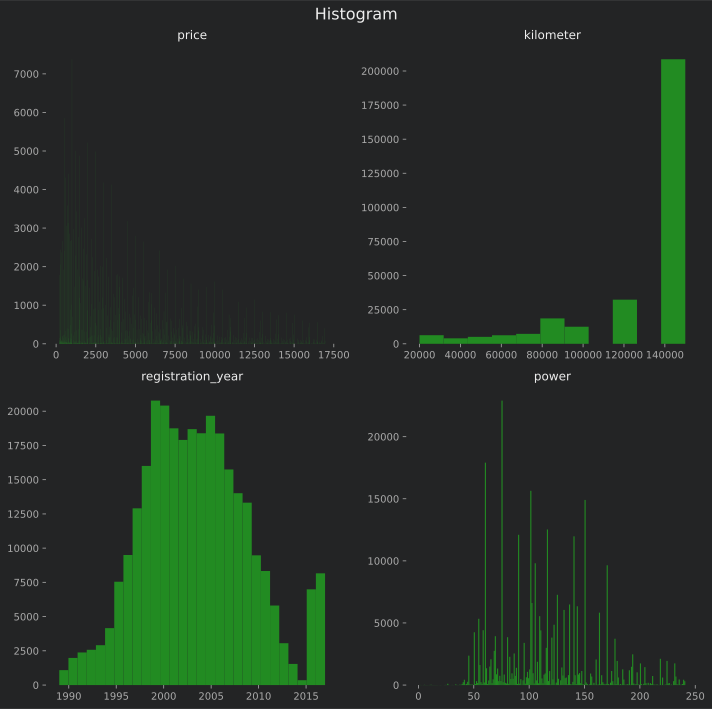

In [69]:
plot_hist(data=autos_df.loc[: ,
        [
            'price',
            'kilometer',
            'registration_year',
            'power',
        ]
   ]
)

In [70]:
display(
    len(
        autos_df.loc[
            autos_df['power'] < 30,
            'registration_year'
        ]
    ),
    autos_df.loc[
        autos_df['power'] < 30,
        [
            'registration_year',
             'brand',
            'model',
            'power',
            'fuel_type',
        ]
    ]
)

258

,registration_year,brand,model,power,fuel_type
3349,2004,volkswagen,polo,7.0,gasoline
3419,2017,trabant,601,26.0,other
4637,2000,ford,focus,16.0,gasoline
11549,1989,trabant,601,26.0,gasoline
15693,1999,opel,astra,22.0,gasoline
...,...,...,...,...,...
344434,1989,citroen,other,27.0,gasoline
344961,2012,renault,other,13.0,electric
346038,1997,mercedes_benz,c_klasse,20.0,gasoline
349031,1989,trabant,601,26.0,gasoline


Менее 30 лошединых сил для `volkswagen polo`, `opel astra`, `ford focus` на бензиновом двигателе явно ошибка..  
Зачистим.

In [71]:
autos_df.drop(
    index=autos_df.loc[
            autos_df['power'] < 30,
        ].index,
    inplace=True,
)

In [72]:
print('Осталось данных после зачистки {:.3%}'.format(
        len(autos_df.index)
        / start_df_length
    )
)

Осталось данных после зачистки 84.812%


In [73]:
display(
    len(autos_df.loc[
            autos_df['power'].isna()
        ].index
    )
)

25

In [74]:
power_by_brand = autos_df.loc[
            autos_df['power'].notna(),
            ['brand', 'power']
    ].groupby(by=['brand'])['power'].quantile(q=0.5, interpolation='nearest',)

In [75]:
autos_df.loc[
            autos_df['power'].isna(),
            'power'
    ] = autos_df.loc[
            autos_df['power'].isna(),
            'brand'
        ].apply(lambda br: power_by_brand.loc[br])

In [77]:
columns_dtype = {
    # 'date_crawled': '_',
    'price': 'uint32',
    'vehicle_type': 'category',
    # 'registration_year': '_',
    'gearbox': 'category',
    'power': 'uint16',
    'model': 'category',
    'kilometer': 'uint32',
    # 'registration_month': '_',
    'fuel_type': 'category',
    'brand': 'category',
    'repaired': 'category',
    # 'date_created': '_',
    'postal_code': 'category',
}
autos_df = autos_df.astype(dtype=columns_dtype)

<hr>

### 2.2. Создадим информативные признаки из неинформативных

У нас есть время загрузки анкет, время создания анкет и время последнего визита. Из этих данных можно узнать как долго анкеты на сайте и как долго отсутствовал владельц на сайте.  
Можно предположить что чем дольше анкета на сайте и чем реже заходит владелец тем выше цена или хуже состояние машины за эти деньги.

In [78]:
amnt_zero_month = len(autos_df.loc[
            autos_df['registration_month'] == 0,
            'registration_month'
        ].index
     )

Заменим `'registration_month' == 0` регистрации авто на случайный из месяцев регистрации.  
Так примерно сохраним распределение месяцев и избавимся от пропусков или ошибок в колонке `'registration_month'`.

In [79]:
autos_df.loc[
        autos_df['registration_month'] == 0,
        'registration_month'
    ] = choice(
            a=autos_df.loc[
                autos_df['registration_month'] != 0,
                'registration_month'
            ],
            size=amnt_zero_month,
            replace=True,
        )

Из `'registration_year'` и `'registration_month'` создадим `date_registration`.  
Если колонки не переименовывать в `'year'` и `'month'` то `Pandas` выдаёт ошибку..

In [80]:
autos_df.rename(columns={
            'registration_year': 'year',
            'registration_month': 'month',
        },
        inplace=True,
   )
autos_df['date_registration'] = pd.to_datetime(
        autos_df.loc[: , ['year', 'month']].assign(DAY=1)
    )

In [81]:
autos_df.drop(
    columns=['year', 'month'],
    inplace=True,
)

In [82]:
autos_df['date_crawled'] = pd.to_datetime(autos_df['date_crawled'])
autos_df['date_created'] = pd.to_datetime(autos_df['date_created'])

In [83]:
date_of_last_pull = autos_df['date_crawled'].max()

In [84]:
print('Крайняя запись извлечена', date_of_last_pull)
print('Минимальный год регистрации', autos_df['date_registration'].min())
print('Крайний год регистрации', autos_df['date_registration'].max())
print('Крайняя дата создания анкеты', autos_df['date_created'].max())

Крайняя запись извлечена 2016-04-07 14:36:58
Минимальный год регистрации 1989-01-01 00:00:00
Крайний год регистрации 2017-12-01 00:00:00
Крайняя дата создания анкеты 2016-04-07 00:00:00


Есть даты регистрации, которые позже чем дата создания анкеты или дата выгрузки данных.  
Либо продают машину, которую купили но ещё ожидают поставки, либо ошибка при вводе данных, либо ошибка в данных.

In [85]:
display(
    len(autos_df.loc[
            autos_df['date_registration'] > autos_df['date_crawled']
        ].index
    ) / start_df_length
)

0.03825955430638685

In [86]:
display(
    len(autos_df.loc[
            autos_df['date_registration'] > autos_df['date_created']
        ].index
    ) / start_df_length,
    len(autos_df.loc[
            autos_df['date_registration'] > autos_df['date_created']
        ].index
    )
)

0.03826519814092091

13560

3.8% таких наперёд зарегистрированных..

Что такое дата регистрации нужно уточнить.  
Предположим, это дата постановки на учёт текущим владельцем.  
Если вычесть из даты извлечения анкеты дату постановки на учёт получим время пользования машиной.  
Хотя, конечно, дата выпуска или начала пользования авто более актуальна. Ну, что есть то есть..

In [87]:
autos_df['days_in_use'] = (
        autos_df['date_crawled']
        - autos_df['date_registration']
    )
autos_df['days_in_use'] = autos_df['days_in_use'].apply(lambda row: row.days)

display(
    autos_df['days_in_use'].describe()
)

count    300547.000000
mean       4517.053193
std        2141.510264
min        -636.000000
25%        3110.000000
50%        4630.000000
75%        6059.000000
max        9957.000000
Name: days_in_use, dtype: float64

### 2.3. Удалим оставшиеся неинформативные признаки

> Если среди признаков имеются неинформативные, удалите их.

In [88]:
display(autos_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300547 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date_crawled       300547 non-null  datetime64[ns]
 1   price              300547 non-null  uint32        
 2   vehicle_type       300547 non-null  category      
 3   gearbox            300547 non-null  category      
 4   power              300547 non-null  uint16        
 5   model              300547 non-null  category      
 6   kilometer          300547 non-null  uint32        
 7   fuel_type          300547 non-null  category      
 8   brand              300547 non-null  category      
 9   repaired           300547 non-null  category      
 10  date_created       300547 non-null  datetime64[ns]
 11  postal_code        300547 non-null  category      
 12  date_registration  300547 non-null  datetime64[ns]
 13  days_in_use        300547 non-null  int64   

None

In [45]:
zip_to_city_state_country = []
for post_c in autos_df['postal_code'].unique():
    r = requests.get(
        f'https://postalcode.parseapi.com/api/{API_KEY}/{post_c}'
    )
    try:
        data = json.loads(r.text)
        continent = data['continent']['name']
        country = data['country']['name']
        state = data['state']['name']
        city = data['city']['name']
        zip_to_city_state_country.append([post_c, continent, country, state, city])
    except ValueError:
        zip_to_city_state_country.append([post_c, np.NaN, np.NaN, np.NaN, np.NaN])

In [47]:
postal_df = pd.DataFrame(
        zip_to_city_state_country,
        columns=['code', 'continent', 'country', 'state', 'city']
    )

In [50]:
unsolved_zip = len(
        postal_df.loc[postal_df['city'].notna(), 'city'].index
    )
solved_zip = len(
        postal_df.loc[postal_df['city'].isna(), 'city'].index
    )
total_unique_zip = len(
        autos_df['postal_code'].unique().index
    )

display(
    postal_df.sample(5)
)
print(
    f'Осталось найти информацию для {unsolved_zip} почтовых индексов.'
)
print(
    f'Нашли информацию для {solved_zip} почтовых индексов.'
)
print(
    'Удалось найти информацию для {:.2%} почтовых индексов.'.format(
        solved_zip / total_unique_zip
    )
)
print(
    f'Но только для {len(postal_df['country'].unique())} стран:',
    postal_df['country'].unique()
)

,code,continent,country,state,city
1987,90451,NaN,NaN,NaN,NaN
6528,81475,NaN,NaN,NaN,NaN
3254,45257,NaN,NaN,NaN,NaN
3391,8056,NaN,NaN,NaN,NaN
7685,92700,NaN,NaN,NaN,NaN


5003

2

Сам по себе индекс мало полезен и скорее даже мешает, но с его помощю можно узнать город, штат и страну продажи авто. Можно на основе `'pоstal_code'` создать колонку со штатами или регионами, в крайнем случаее городами. Это уменьшит количество классов и поидее повысит точность модели. Есть предположение, что цена немного зависит от города, штата и страны продажы. Можно получить эти данные через api, но вот только с помощью `postalcode.parseapi.com` удалось найти часть геолокаций.  
Думаю, для учебного проекта, достаточно обозначить саму возможность. В реальности можно добыть данные, но нужно знать в какой стране искать. Потомучто одинаковые почтовые индексы могут быть в разных странах..  
Поэтому удалим колонку.. 🤫

In [92]:
autos_df.drop(columns='postal_code', inplace=True)

KeyError: "['postal_code'] not found in axis"

In [127]:
col_category = [
        'vehicle_type',
        'gearbox',
        'model',
        'fuel_type',
        'brand',
        'repaired',
        # 'postal_code',
    ]

col_numeric = [
        'power',
        'kilometer',
        'days_in_use',
    ]

In [95]:
col_to_drop = [
        'date_crawled',
        'date_created',
        'date_registration',
    ]

autos_df.drop(
    columns=col_to_drop,
    inplace=True,
)

<hr>

### 3.1. Подготовим выборки для обучения моделей

In [96]:
target = autos_df['price']
features = autos_df.drop(
        columns='price'
    )

In [97]:
features_train, features_test, target_train, target_test  = train_test_split(
        features,
        target,
        test_size=.25,
        random_state=RANDOM_SEED,
    )

> Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.

<hr>

#### LightGBM

> Разработка компании Microsoft, быстро и точно обучает
градиентный бустинг. Работает с категориальными признаками
напрямую. Вышла в 2017 году. Сравнение с XGBoost:
[Experiments](https://lightgbm.readthedocs.io/en/latest/Experiments.html)

In [98]:
light_regressor = lightgbm.LGBMRegressor(
        random_state=RANDOM_SEED,
    )

light_regressor.fit(features_train, target_train)

LGBMRegressor(random_state=108108108)

In [99]:
light_pred = light_regressor.predict(features_test)
light_r2 = r2_score(target_test, light_pred)

display(light_r2)

0.8673775037399695

In [100]:
# create a KFold object with 5 splits 
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [101]:
params = {
        'boosting_type': ['gbdt'],
        'num_leaves': [31, 37],
        'max_depth': [-1, 27],
        # 'learning_rate': [0.1, 0.05, 0.005],
        'n_estimators': [150, 100], # default: 100
        'objective': ['regression'], # default: ‘regression’ for LGBMRegressor
        # 'min_child_weight': [0.001, ],
        'min_child_samples': [10, 20, 40],
        'subsample': [1.0],
        'subsample_freq': [0, 1],
        'colsample_bytree': [1.0, ],
        'random_state': [RANDOM_SEED, ],
        'n_jobs': [-1],
        'importance_type': ['split', 'gain'],
    }

количество параметров для `GridSearchCV` снизил, потомучто долго отрабатывает..

In [102]:
rmse_scorer = make_scorer(
        mean_squared_error,
        greater_is_better=False,
        squared=False,
    )

In [103]:
light_reg_cv = GridSearchCV(
    light_regressor,
    params,
    scoring=rmse_scorer,
    n_jobs=-1,
    refit=True,
    cv=folds,
    # verbose=0,
    # pre_dispatch='2*n_jobs',
    # error_score=nan,
    return_train_score=True,
)

In [104]:
%%timeit

light_reg_cv.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=108108108, shuffle=True),
             estimator=LGBMRegressor(random_state=108108108), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'colsample_bytree': [1.0],
                         'importance_type': ['split', 'gain'],
                         'max_depth': [-1, 27],
                         'min_child_samples': [10, 20, 40],
                         'n_estimators': [150, 100], 'n_jobs': [-1],
                         'num_leaves': [31, 37], 'objective': ['regression'],
                         'random_state': [108108108], 'subsample': [1.0],
                         'subsample_freq': [0, 1]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [111]:
display(
    light_reg_cv.best_score_,
    light_reg_cv.best_params_,
)

-1375.5829028209935

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'max_depth': -1,
 'min_child_samples': 10,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_leaves': 37,
 'objective': 'regression',
 'random_state': 108108108,
 'subsample': 1.0,
 'subsample_freq': 0}

In [105]:
%%timeit  -n10 -r3

light_reg_cv.predict(features_test)

561 ms ± 9.78 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Посмотрим сколько времени занимает прогноз стоимости для одного автомобиля.

In [106]:
features_test_sample = features_test.sample(
        n=1,
        random_state=RANDOM_SEED,
    )

In [107]:
%%timeit  -n100 -r3

light_reg_cv.predict(features_test_sample)

7.44 ms ± 189 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [108]:
light_reg_cv_pred_sample = light_reg_cv.predict(features_test_sample)

In [109]:
display(features_test_sample)
print(
    'прогноз стомости автомобиля {:.2f} €'.format(
        light_reg_cv_pred_sample[0]
    )
)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,days_in_use
202446,sedan,auto,95,a_klasse,150000,gasoline,mercedes_benz,no,-486


прогноз стомости автомобиля 1838.44 €


`TypeError: 'DataFrame' object is not callable`  

Не получилось разобраться с `big_o`, хотел оценить `time complexity` 

In [113]:
light_reg_cv_pred = light_reg_cv.predict(features_test)
light_reg_cv_r2 = r2_score(target_test, light_reg_cv_pred)

In [114]:
light_reg_cv_rmse = mean_squared_error(
        target_test,
        light_reg_cv_pred,
        squared=False,
    )

In [115]:
print(
    'RMSE для LGBMRegressor {:.2f}'.format(
        light_reg_cv_rmse
    )
)
print(
    'R2 для LGBMRegressor {:.3f}'.format(
        light_reg_cv_r2
    )
)

RMSE для LGBMRegressor 1395.38
R2 для LGBMRegressor 0.872


<hr>

#### CatBoost

> CatBoost (от англ. categorical boosting; «бустинг для категориальных признаков»). Разработка Яндекса, превосходит другие алгоритмы по метрикам качества. Применяет различные техники кодирования категориальных признаков (LabelEncoding, One-Hot Encoding*). Вышла в 2017 году. Сравнение с XGBoost и LightGBM:  
[benchmark](https://catboost.ai/#benchmark)

In [116]:
cat_model = CatBoostRegressor(
        loss_function='RMSE',
        iterations=500,
        cat_features=None,
        random_seed=RANDOM_SEED,
        verbose=False,
    )

In [119]:
%%timeit -n1 -r1

cat_model.fit(
    features_train,
    target_train,
    cat_features=col_category,
)

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [120]:
features_test_sample = features_test.sample(
        n=1,
        random_state=RANDOM_SEED,
    )

In [121]:
%%timeit  -n100 -r3

cat_model.predict(features_test_sample)

1.72 ms ± 268 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [122]:
cat_model_pred_sample = cat_model.predict(features_test_sample)

In [123]:
display(features_test_sample)
print(
    'прогноз стомости автомобиля {:.2f} €'.format(
        cat_model_pred_sample[0]
    )
)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,days_in_use
202446,sedan,auto,95,a_klasse,150000,gasoline,mercedes_benz,no,-486


прогноз стомости автомобиля 1975.37 €


In [124]:
cat_pred = cat_model.predict(features_test)
cat_r2 = r2_score(target_test, cat_pred)

In [125]:
cat_rmse = mean_squared_error(
        target_test,
        cat_pred,
        squared=False,
    )

In [126]:
print(
    'RMSE для CatBoostRegressor {:.2f}'.format(
        cat_rmse
    )
)
print(
    'R2 для CatBoostRegressor {:.3f}'.format(
        cat_r2
    )
)

RMSE для CatBoostRegressor 1413.59
R2 для CatBoostRegressor 0.869


<hr>

#### Support Vector Regression (SVR)

In [130]:
# svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

In [185]:
display(
    features_train,
    col_category,
)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code,days_in_use
341423,small,manual,45,polo,150000,gasoline,volkswagen,no,13403,7226
94068,sedan,manual,102,beetle,40000,gasoline,volkswagen,no,57319,1918
93776,sedan,auto,224,e_klasse,150000,gasoline,mercedes_benz,no,22119,4722
93260,convertible,manual,94,other,150000,gasoline,fiat,no,51674,7346
81460,sedan,manual,115,3er,150000,gasoline,bmw,no,23858,7188
...,...,...,...,...,...,...,...,...,...,...
151776,wagon,manual,105,focus,150000,gasoline,ford,yes,56154,3387
226193,sedan,manual,122,1er,50000,gasoline,bmw,no,49124,2105
119853,coupe,auto,204,e_klasse,150000,gasoline,mercedes_benz,no,76571,8029
15257,sedan,manual,150,5er,150000,gasoline,bmw,yes,65931,6787


['vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired',
 'postal_code']

In [128]:
ohe = OneHotEncoder(
        drop='first',
    )

ohe.fit(features_train)
features_train_adj = ohe.transform(features_train)

display(
    features_train_adj.shape()
)

<225410x10780 sparse matrix of type '<class 'numpy.float64'>'
	with 1763241 stored elements in Compressed Sparse Row format>

In [ ]:
%%timeit

# svr_rbf.fit(features_train_adj, target_train)
# svr_lin.fit(features_train_adj, target_train)
# svr_poly.fit(features_train_adj, target_train)

Даже одно обучение `svr_poly` длится уже более 4 часов, поэтому остановил, закомментировал. Хотел разные попробывать настройки, но ждать слишком долго..

LinearRegression

In [ ]:
# lin_reg = LinearRegression()
# lin_reg.fit(features_train_adj, target_train)

In [ ]:
 Тоже, очень долго отрабатывает обучение.. Но Jupyter работает..

## Итог

В данных много пропусков `NaN`, например параметрт `repaired` содержит 20% пропусков..  
Много выбросов или ошибок в данных.
Есть совершенно бесполезные данные или ошибка в данных, например `number_of_pictures` содержит только нули. 
~ 3% данных не содержат целевого признака `price`, то есть он равен нулю, хотя, конечно не стоит исключать мизерную вероятность того, что владельцы готовы подарить машину)  
  
Подстригли выбросы  во 99% интервалу в числовых столбцах. Удалили немыслимые мощности и машины из будущего и далёкого прошлого.  
Восстановили часть данных по имеющимся, например мощность по бренду, модели и типу топлева.  
Всего в создании модели использовали 84.812% данных, маловато, конечно, но ведь и точность предсказания важна.  
Создали признак время владения автомобилем из даты выгрузки вычитаем дату регистрации. Предположим, что продают машину ещё не полученную, когда дата выгрузки анкеты раньше даты регистрации. Таких данных 3,8%. Хотя, конечно, о признаках `registration_month`, `registration_year` нужно было бы уточнить..  
Из почтовых индексов можно получить страну, штат или регион и город. Но для полной картины не хватает данных о странах в которых искать.  
  
Обучили LightGBM, CatBoost.
CatBoost показал лучшие результаты и по точности, и по скорости обучения, и по скорости предсказаний, и по точности предсказаний.

Основные шаги:

- Загрузите данные, путь к файлу: /datasets/autos.csv.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
    - Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.